In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from mmf_speckle import *
from __init__ import *

In [3]:
import torch
import matplotlib.pyplot as plt
import h5py
import time

In [4]:
tower_images = np.array(h5py.File("./timg/towers.h5")["Imgs"])

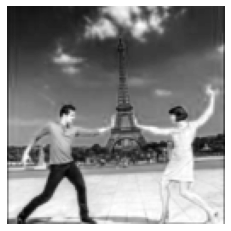

In [5]:
plt.imshow(tower_images[0,0,:,:], cmap="gray")
plt.axis("off")
plt.show()

In [6]:
device="cuda"
dtype=torch.float32
isfloat64=False
root="./results"

## Data Preparation

In [7]:
nosie=False
nosie_sigma=0

In [8]:
# unknow measurement
A_u = get_mmf_speckle_measure_matrix(25,device,dtype)
# reconstruction of 7 unknown images
names=[
    "GI",
    "Baboon",
    "Peppers",
    "Goldhill",
    "Barbara",
    "Cameraman",
    "Lena"
]
y_u_list = []
x_u_list = []
for name in names:
    x_u = get_gi_image(0,device, dtype) if name=="GI" else get_t_image(name,device, dtype)
    y_u = speckle_measure(A_u, x_u.reshape((-1,1)), nosie=nosie, nosie_sigma=nosie_sigma)
    x_u_list.append(x_u)
    y_u_list.append(y_u)

## Start Recv

In [9]:
A = get_mmf_speckle_measure_matrix(0,device,dtype)
# Test three types of pre-measure images
PM_images = [
    get_gi_image(0, device, dtype).reshape((-1,1)),  # PM1 
    torch.tensor(tower_images[0,0,:,:],device=device,dtype=dtype).reshape((-1,1)), # PM2
    get_pre_measure_img(device, dtype).reshape((-1,1))   # PM3
]

### Exp0: PM image

In [ ]:
# Iterative Algorithm 1
epoches = [500,100,100]
for i in range(len(PM_images)):
    f = h5py.File("{}/exp0/algo1/PM{}.h5".format(root,i+1),"a")
    pm_idx = i
    recv_u_idx = 1
    x_u = x_u_list[recv_u_idx].reshape((-1,1))
    params_1 = {
        "A": A,
        "PM_image": PM_images[pm_idx],
        "epoch": epoches[i],
        "speckle_measure": lambda A: speckle_measure(A, x_u, nosie=nosie, nosie_sigma=nosie_sigma),
        "A_recv":None,
        "e_y":None,
        "calc_error": lambda A: A @ x_u
    }
    decay_k = calc_iterative_algo_k(params_1["A"], params_1["PM_image"], x_u) 
    y_u = y_u_list[recv_u_idx]
    A_recv, errors = iterative_algo_1(y_u, params_1, verbose=True)
    print("done")
    f.create_dataset("A_recv", data=A_recv.cpu().numpy())
    f.create_dataset("y_u", data=y_u.cpu().numpy())
    
    f.create_dataset("errors", data=np.array(errors))
    f.create_dataset("decay_k", data=decay_k.cpu().numpy())    
    f.close()

In [ ]:
# Iterative Algorithm 2
epoches = [500,100,100]
for i in range(len(PM_images)):
    f = h5py.File("{}/exp0/algo2/PM{}.h5".format(root,i+1),"a")
    
    pm_idx = i
    recv_u_idx = 1
    x_u = x_u_list[recv_u_idx].reshape((-1,1))
    
    params_2 = {
        "A": A,
        "PM_image": PM_images[pm_idx],
        "PM_epoch": 20,
        "epoch": epoches[i],
        "speckle_measure": lambda A: speckle_measure(A, x_u, nosie=nosie, nosie_sigma=nosie_sigma),
        "A_recv":None,
        "e_y":None,
        "isfloat64":isfloat64,
        "calc_error": lambda A: A @ x_u
    }

    decay_k = calc_iterative_algo_k(params_2["A"], params_2["PM_image"], x_u) 
    y_u = y_u_list[recv_u_idx]
    (A_recv, k), pm_errors, errors, times = iterative_algo_2(y_u, params_2, verbose=True)
    
    print("done")
    f.create_dataset("A_recv", data=A_recv.cpu().numpy())
    f.create_dataset("y_u", data=y_u.cpu().numpy())
    
    f.create_dataset("errors", data=np.array(errors))
    f.create_dataset("pm_errors", data=np.array(pm_errors))
    
    f.create_dataset("decay_k", data=decay_k.cpu().numpy())
    f.create_dataset("times", data=np.array([times]))    
    
    f.create_dataset("epoches", data=np.array([epoches[i]]))   
    
    f.close()

### Visualization

In [16]:
# algo1
algo1_errors_list = []
algo1_decay_k_list = []
for i in range(len(PM_images)):
    f = h5py.File("{}/exp0/algo1/PM{}.h5".format(root,i+1))
    algo1_errors_list.append(np.array(f["errors"]))
    algo1_decay_k_list.append(np.array(f["decay_k"]))
    
    
# algo2
algo2_errors_list = []
algo2_decay_k_list = []
for i in range(len(PM_images)):
    f = h5py.File("{}/exp0/algo2/PM{}.h5".format(root,i+1))
    algo2_errors_list.append(np.array(f["errors"]))
    algo2_decay_k_list.append(np.array(f["decay_k"]))

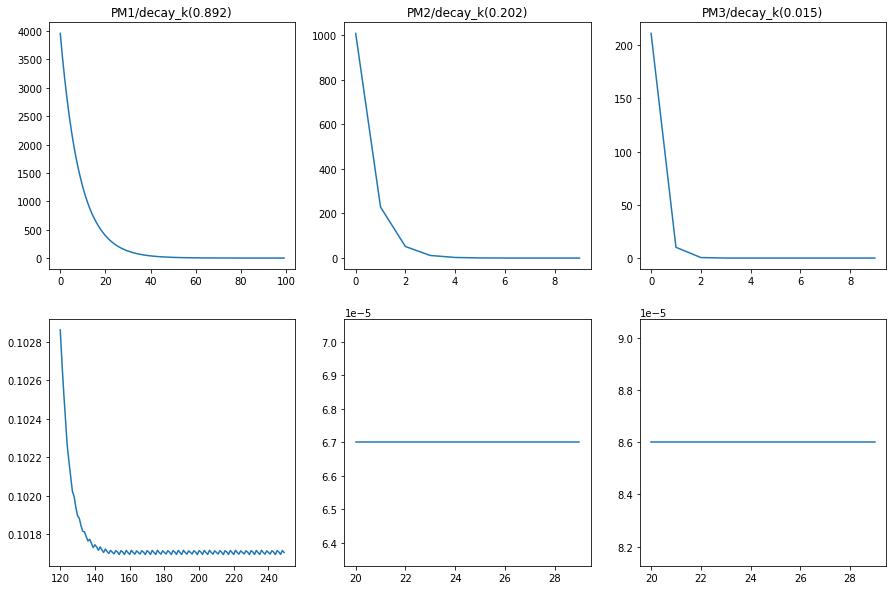

In [18]:
plt.figure(figsize = (3*5, 2*5))
for i in range(len(PM_images)):
    er = algo1_errors_list[i]
    x_range = range(len(er))
    decay_k = algo1_decay_k_list[i][0][0]
    
    if i==0:
        plt.subplot(2,3,i+1)
        plt.plot(x_range[0:100],er[0:100])
        plt.title("PM{}/decay_k({})".format(i+1, abs(round(decay_k,3))))
        
        plt.subplot(2,3,i+1+3)
        plt.plot(x_range[120:250],er[120:250])
        
    else:
        plt.subplot(2,3,i+1)
        plt.plot(x_range[0:10],er[0:10])
        plt.title("PM{}/decay_k({})".format(i+1, abs(round(decay_k,3))))
        
        plt.subplot(2,3,i+1+3)
        plt.plot(x_range[20:30],np.round(er[20:30],6))
        
# plt.show()
plt.savefig("./results/exp0/algo1-curve.jpg")

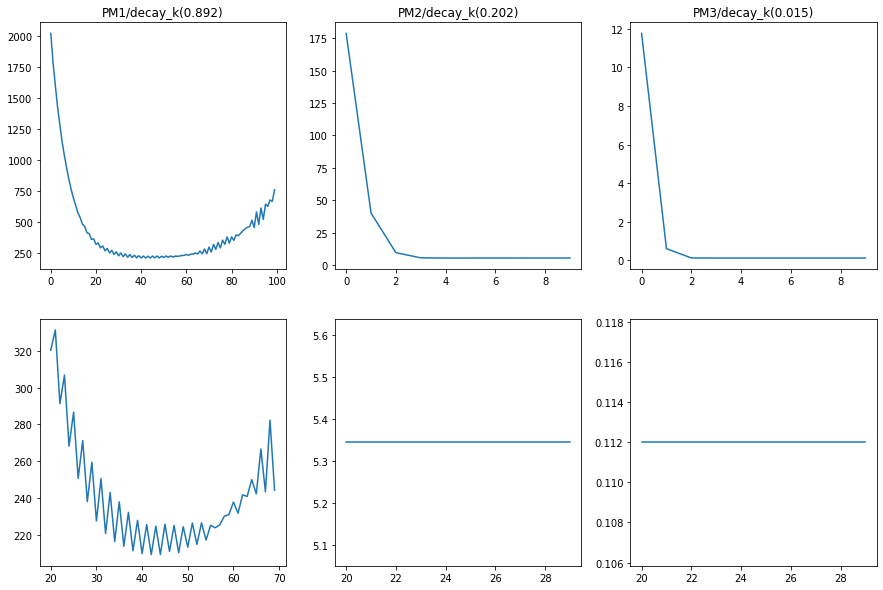

In [25]:
plt.figure(figsize = (3*5, 2*5))
for i in range(len(PM_images)):
    er = algo2_errors_list[i]
    x_range = range(len(er))
    decay_k = algo2_decay_k_list[i][0][0]
    
    if i==0:
        plt.subplot(2,3,i+1)
        plt.plot(x_range[0:100],er[0:100])
        plt.title("PM{}/decay_k({})".format(i+1, abs(round(decay_k,3))))
        
        plt.subplot(2,3,i+1+3)
        plt.plot(x_range[20:70],er[20:70])
        
    else:
        plt.subplot(2,3,i+1)
        plt.plot(x_range[0:10],er[0:10])
        plt.title("PM{}/decay_k({})".format(i+1, abs(round(decay_k,3))))
        
        plt.subplot(2,3,i+1+3)
        plt.plot(x_range[20:30], np.round(er[20:30],3))
        
# plt.show()
plt.savefig("./results/exp0/algo2-curve.jpg")

PM1/decay_k(0.892)
PM2/decay_k(0.202)
PM3/decay_k(0.015)


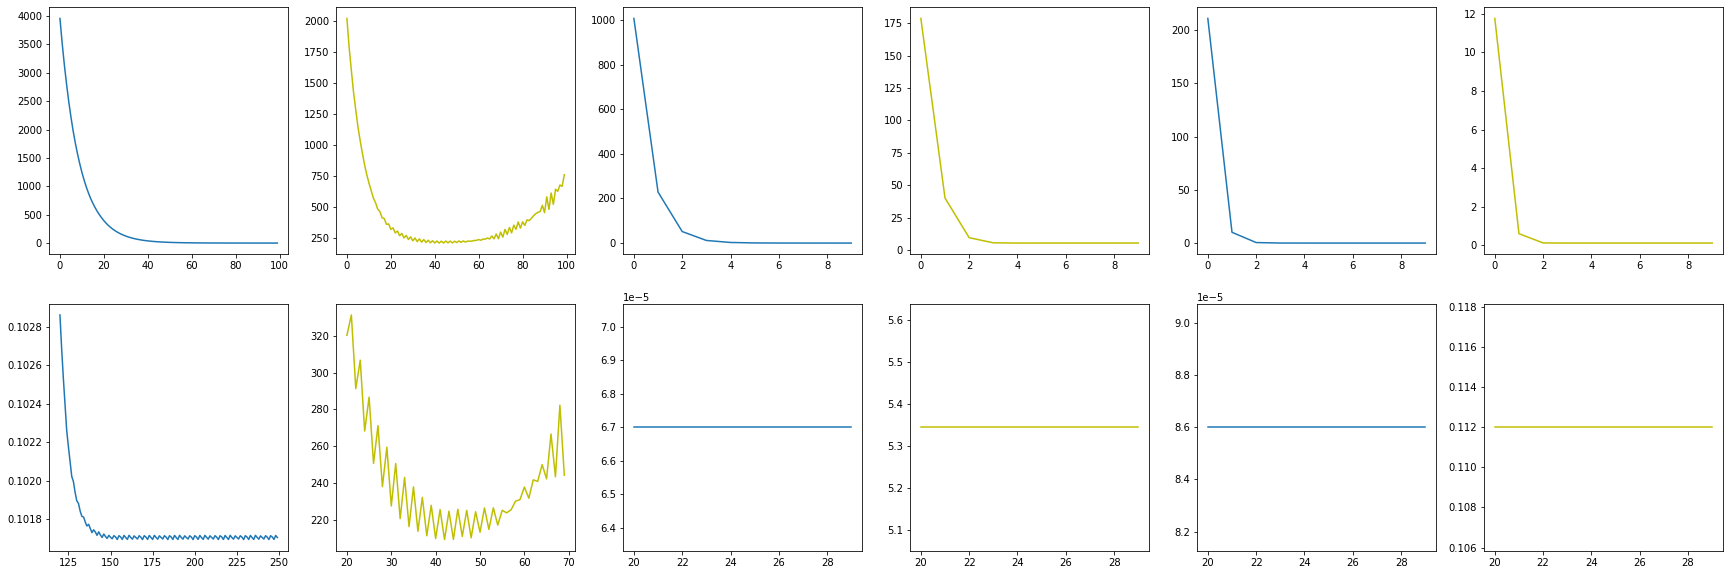

In [34]:
plt.figure(figsize = (6*5, 2*5))
for i in range(len(PM_images)):
    er = algo1_errors_list[i]
    x_range = range(len(er))
    decay_k = algo1_decay_k_list[i][0][0]  # decay_k algo1 and algo2 is the same
    
    er2 = algo2_errors_list[i]
    print("PM{}/decay_k({})".format(i+1, abs(round(decay_k,3))))
    
    if i==0:
        plt.subplot(2,6,i+1)
        plt.plot(x_range[0:100],er[0:100])
        
        plt.subplot(2,6,i+2)
        plt.plot(x_range[0:100],er2[0:100],c="y")
        
        plt.subplot(2,6,i+1+6)
        plt.plot(x_range[120:250],er[120:250])
        
        plt.subplot(2,6,i+1+7)
        plt.plot(x_range[20:70],er2[20:70],c="y")
        
    else:
        plt.subplot(2,6,2*i+1)
        plt.plot(x_range[0:10],er[0:10])
        
        plt.subplot(2,6,2*i+2)
        plt.plot(x_range[0:10],er2[0:10],c="y")
        
        
        plt.subplot(2,6,2*i+1+6)
        plt.plot(x_range[20:30],np.round(er[20:30],6))
        
        plt.subplot(2,6,2*i+1+7)
        plt.plot(x_range[20:30], np.round(er2[20:30],3), c="y")
        
# plt.show()
# plt.savefig("./results/exp0/algos-curve.jpg")

### Exp1: for 7 images

In [37]:
# Iterative Algorithm 2
for j in range(len(names)):
    name = names[j]
    f = h5py.File("./results/exp1/algo2/{}.h5".format(name),"a")

    pm_idx = 2
    recv_u_idx = j

    x_u = x_u_list[recv_u_idx].reshape((-1,1))

    params_2 = {
        "A": A,
        "PM_image": PM_images[pm_idx],
        "PM_epoch": 20,
        "epoch": 100,
        "speckle_measure": lambda A: speckle_measure(A, x_u, nosie=nosie, nosie_sigma=nosie_sigma),
        "A_recv":None,
        "e_y":None,
        "isfloat64":isfloat64,
        "calc_error": lambda A: A @ x_u
    }

    decay_k = calc_iterative_algo_k(params_2["A"], params_2["PM_image"], x_u) 
    y_u = y_u_list[recv_u_idx]
    (A_recv, k), pm_errors, errors, times = iterative_algo_2(y_u, params_2, verbose=False)
    print(errors[-1],"done")
   
    f.create_dataset("A_recv", data=A_recv.cpu().numpy())
    f.create_dataset("y_u", data=y_u.cpu().numpy())

    f.create_dataset("errors", data=np.array(errors))
    f.create_dataset("pm_errors", data=np.array(pm_errors))

    f.create_dataset("decay_k", data=decay_k.cpu().numpy())
    f.create_dataset("times", data=np.array([times]))   

    f.create_dataset("PM_epoch", data=np.array([params_2["PM_epoch"]]))  
    f.create_dataset("epoch", data=np.array([params_2["epoch"]]))   

    f.close()

tensor([[0.2630],
        [0.2627],
        [0.2637],
        ...,
        [0.2635],
        [0.2630],
        [0.2625]], device='cuda:0')
0.1006271 done
tensor([[1.0154],
        [1.0160],
        [1.0149],
        ...,
        [1.0150],
        [1.0149],
        [1.0153]], device='cuda:0')
0.1120581 done
tensor([[0.8198],
        [0.8203],
        [0.8197],
        ...,
        [0.8211],
        [0.8216],
        [0.8204]], device='cuda:0')
0.15272051 done
tensor([[0.8828],
        [0.8815],
        [0.8815],
        ...,
        [0.8817],
        [0.8809],
        [0.8824]], device='cuda:0')
0.15873623 done
tensor([[0.8818],
        [0.8824],
        [0.8832],
        ...,
        [0.8809],
        [0.8820],
        [0.8820]], device='cuda:0')
0.15214092 done
tensor([[0.9318],
        [0.9317],
        [0.9332],
        ...,
        [0.9332],
        [0.9304],
        [0.9307]], device='cuda:0')
0.23129883 done
tensor([[0.9736],
        [0.9730],
        [0.9746],
        ...,
     

In [39]:
# Iterative Algorithm 1
for j in range(len(names)):
    name = names[j]
    f = h5py.File("./results/exp1/algo1/{}.h5".format(name),"a")

    pm_idx = 2
    recv_u_idx = j

    x_u = x_u_list[recv_u_idx].reshape((-1,1))

    params_1 = {
        "A": A,
        "PM_image": PM_images[pm_idx],
        "epoch": 100,
        "speckle_measure": lambda A: speckle_measure(A, x_u, nosie=nosie, nosie_sigma=nosie_sigma),
        "A_recv":None,
        "e_y":None,
        "calc_error": lambda A: A @ x_u
    }
    decay_k = calc_iterative_algo_k(params_1["A"], params_1["PM_image"], x_u) 
    y_u = y_u_list[recv_u_idx]
    A_recv, errors = iterative_algo_1(y_u, params_1, verbose=False)
   
    print(errors[-1],"done")
   
    f.create_dataset("A_recv", data=A_recv.cpu().numpy())
    f.create_dataset("y_u", data=y_u.cpu().numpy())
    f.create_dataset("errors", data=np.array(errors))
    f.create_dataset("decay_k", data=decay_k.cpu().numpy()) 
    f.close()

5.620117e-05 done
8.6132815e-05 done
6.933594e-05 done
7.2851566e-05 done
7.03125e-05 done
7.255859e-05 done
7.333984e-05 done
